In [1]:
import pandas as pd
df = pd.read_excel(open('/Users/ymzhang/Desktop/city_pressure1.xlsx','rb'), sheetname='Sheet0')

In [2]:
df.rename(columns={'full_name':'city'}, inplace=True)

In [3]:
df.columns

Index(['order_date', 'city', 'grid_id', 'grid_name', 'pressure_ratio',
       'pressure_ratio_90', 'pressure_ratio_75', 'rider_load', 'rider_load_90',
       'rider_load_75', 'eleme_order_cnt', 'tracking_order_cnt',
       'completion_cnt', 'time_cost', 'overtime_cnt', 'overtime_cnt_40',
       'cancel_order_cnt', 'fraud_cnt', 'completion_rate', 'overtime_rate',
       'overtime_rate_40', 'cancel_rate'],
      dtype='object')

In [4]:
df.completion_rate=round(df.completion_rate,2)
df.pressure_ratio=round(df.pressure_ratio,2)
df.time_cost=round(df.time_cost/60,0)
df.overtime_rate=round(df.overtime_rate,2)
df.overtime_rate_40=round(df.overtime_rate_40,2)
df.cancel_rate=round(df.cancel_rate,2)

In [5]:
names=['order_date','city','grid_id','pressure_ratio_75','time_cost','completion_rate','overtime_rate','overtime_rate_40','cancel_rate']
names1=['pressure_ratio_75','time_cost','completion_rate','overtime_rate','overtime_rate_40','cancel_rate']

In [6]:
df1=df[names]
df2=df[names1]

In [7]:
df3=df1.dropna()

In [8]:
from sklearn.ensemble import IsolationForest
import numpy as np
rng = np.random.RandomState(42)
clf=IsolationForest(max_samples=100,random_state=rng)
clf.fit(df3[names1])
df1_pred=clf.predict(df3[names1])
pred=pd.Series(df1_pred)

In [9]:
pred.value_counts()

 1    61378
-1     6820
dtype: int64

In [10]:
index = [i for i,x in enumerate(pred) if x == 1]
df4=df3.ix[index]

In [11]:
df5=df4.ix[((df4.pressure_ratio_75<1.5)&(df4.pressure_ratio_75>0.1)&(df4.overtime_rate<=0.5)&(df4.cancel_rate<=0.2)) ,]

In [12]:
df5[names1].describe()

,pressure_ratio_75,time_cost,completion_rate,overtime_rate,overtime_rate_40,cancel_rate
count,56972.000000,56972.000000,56972.000000,56972.000000,56972.000000,56972.000000
mean,0.402270,33.054781,0.970326,0.026550,0.250550,0.001642
std,0.181075,5.901317,0.056115,0.042654,0.164959,0.006382
min,0.100457,12.000000,0.290000,0.000000,0.000000,0.000000
25%,0.276328,29.000000,0.970000,0.000000,0.120000,0.000000
50%,0.362500,32.000000,0.990000,0.010000,0.220000,0.000000
75%,0.485714,36.000000,1.000000,0.030000,0.350000,0.000000
max,1.492754,82.000000,1.000000,0.500000,1.000000,0.180000


In [13]:
df5_beijing=df5.ix[(df5.city=='北京市'),]

In [14]:
import seaborn as sns
%matplotlib inline

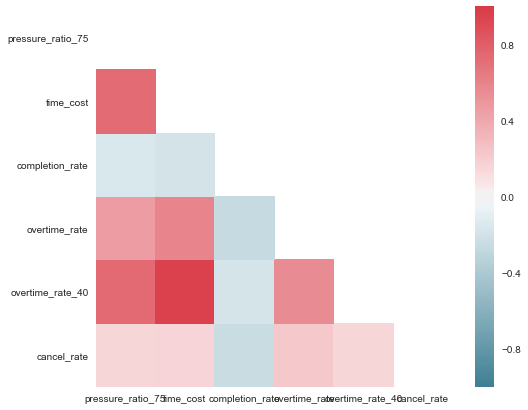

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
# Generate a large random dataset
d = pd.DataFrame(data=df5,columns=names1)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [16]:
corr

,pressure_ratio_75,time_cost,completion_rate,overtime_rate,overtime_rate_40,cancel_rate
pressure_ratio_75,1.000000,0.734314,-0.152372,0.468114,0.736542,0.148677
time_cost,0.734314,1.000000,-0.190512,0.596972,0.957159,0.157325
completion_rate,-0.152372,-0.190512,1.000000,-0.258780,-0.184591,-0.249620
overtime_rate,0.468114,0.596972,-0.258780,1.000000,0.558002,0.225626
overtime_rate_40,0.736542,0.957159,-0.184591,0.558002,1.000000,0.156000
cancel_rate,0.148677,0.157325,-0.249620,0.225626,0.156000,1.000000


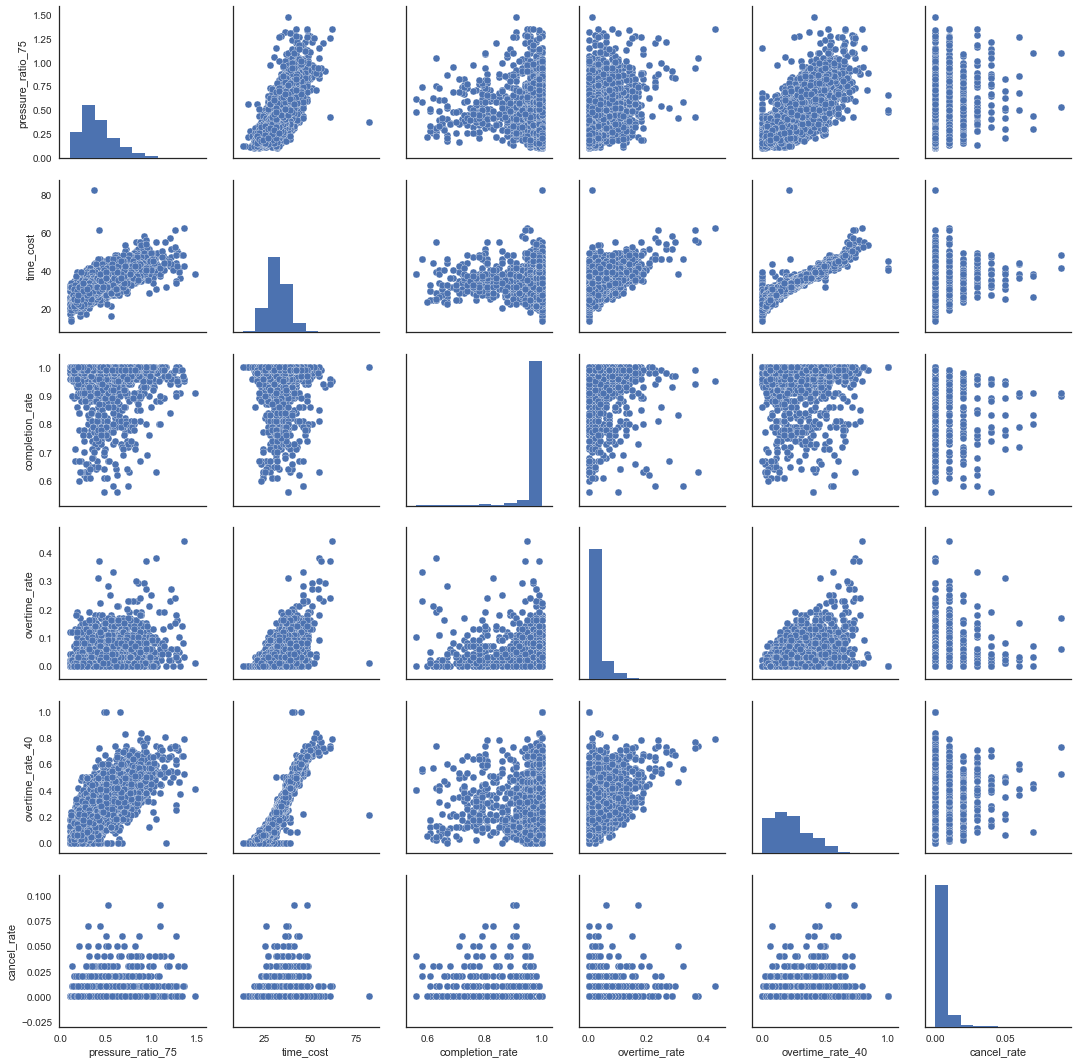

In [17]:
sns.pairplot(df5_beijing[names1])

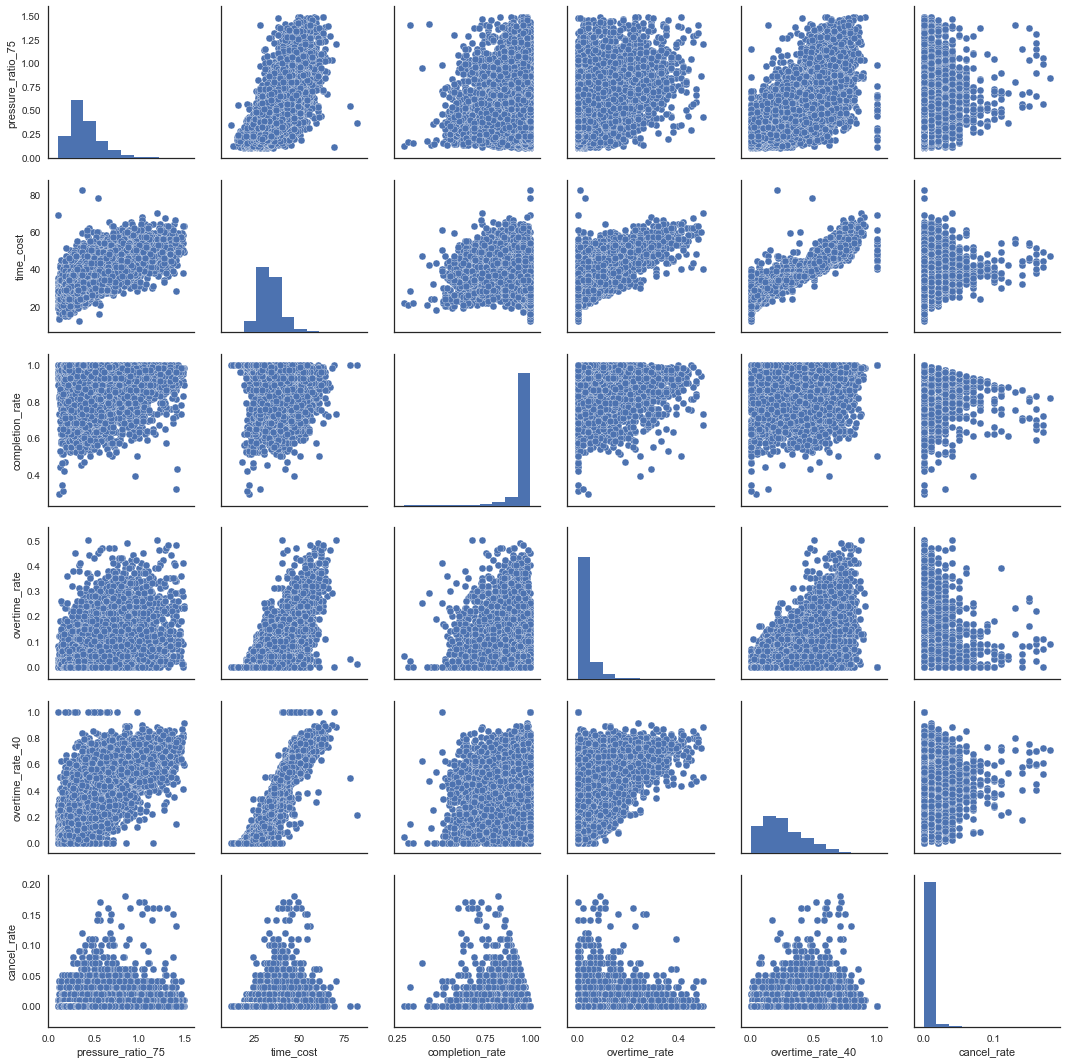

In [18]:
sns.pairplot(df5[names1])

In [20]:
from sklearn.linear_model import LinearRegression
def df5_lm_std(x):
    pressure = pd.DataFrame(df5.ix[x.index].pressure_ratio_75)
    lm = LinearRegression().fit(pressure, x)    
    threshold = np.mean(x)+1.5*np.std(x)    
    return (threshold-lm.intercept_)/lm.coef_[0]
result=df5.groupby('city').agg({'overtime_rate_40': df5_lm_std,
                         'overtime_rate': df5_lm_std,
                         'cancel_rate': df5_lm_std,
                         'time_cost': df5_lm_std})
result

,overtime_rate_40,overtime_rate,cancel_rate,time_cost
city,,,,
三亚市,0.625502,0.816681,94.358096,0.628434
东莞市,0.543798,0.629416,3.593013,0.559440
中山市,0.708675,0.881508,3.344905,0.689507
临沂市,0.681429,0.818039,-15.009125,0.693565
义乌市,0.665462,0.776400,1.273702,0.687886
九江市,0.685657,0.813370,-1.431966,0.693412
佛山市,0.643787,0.724565,2.012905,0.635787
兰州市,0.691534,0.727116,-4.944263,0.676250
包头市,0.536193,1.572856,2.957584,0.533349


In [21]:
df5['pressure_ratio1']=round(df5.pressure_ratio_75,1)
df5_beijing['pressure_ratio1']=round(df5_beijing.pressure_ratio_75,1)
df5['pressure_ratio1'] = df5['pressure_ratio1'].astype('category')
df5_beijing['pressure_ratio1'] = df5_beijing['pressure_ratio1'].astype('category')

/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

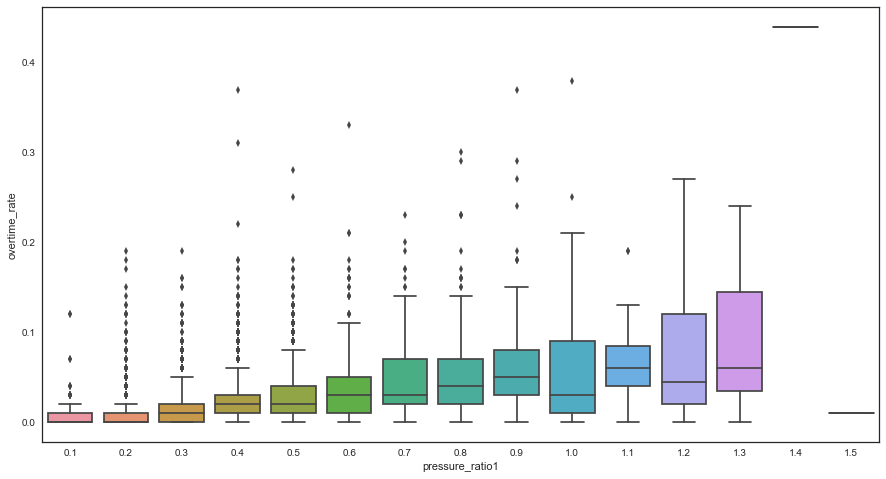

In [22]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='overtime_rate',data=df5_beijing)

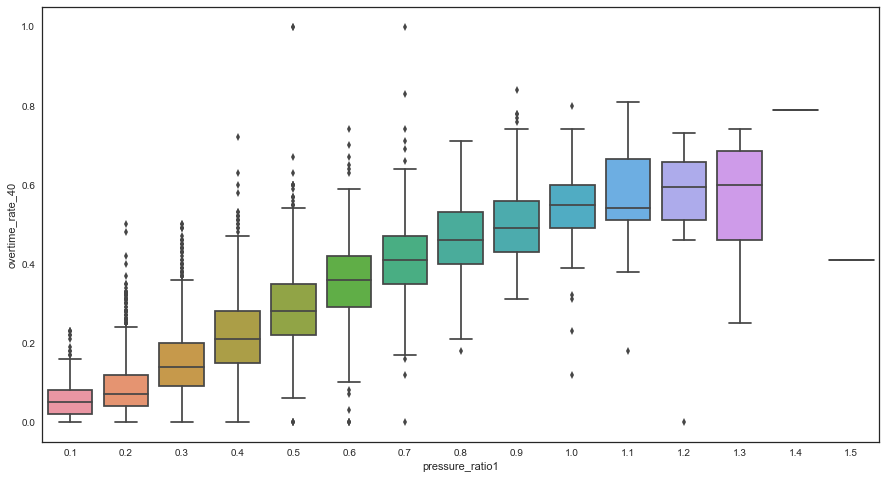

In [23]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='overtime_rate_40',data=df5_beijing)

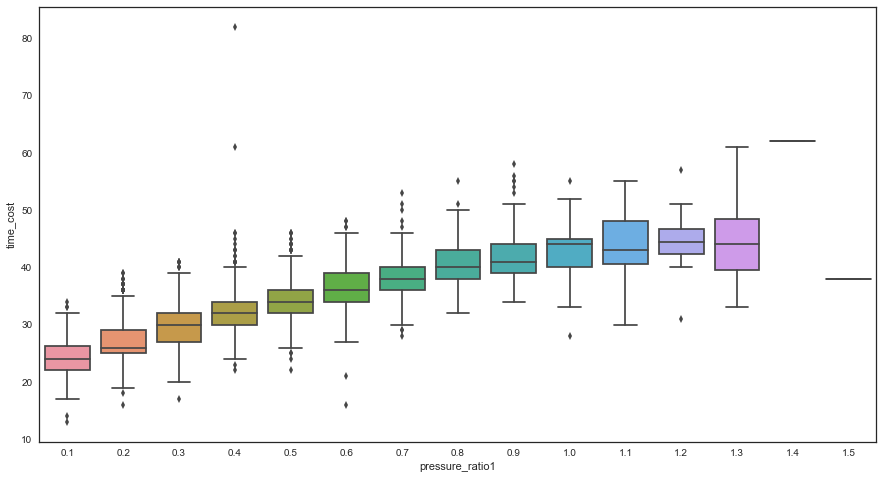

In [24]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='time_cost',data=df5_beijing)

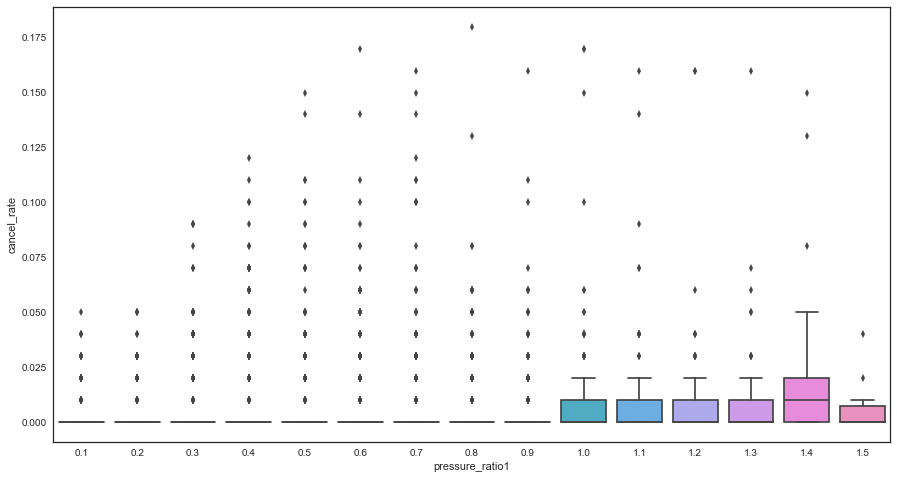

In [25]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='cancel_rate',data=df5)

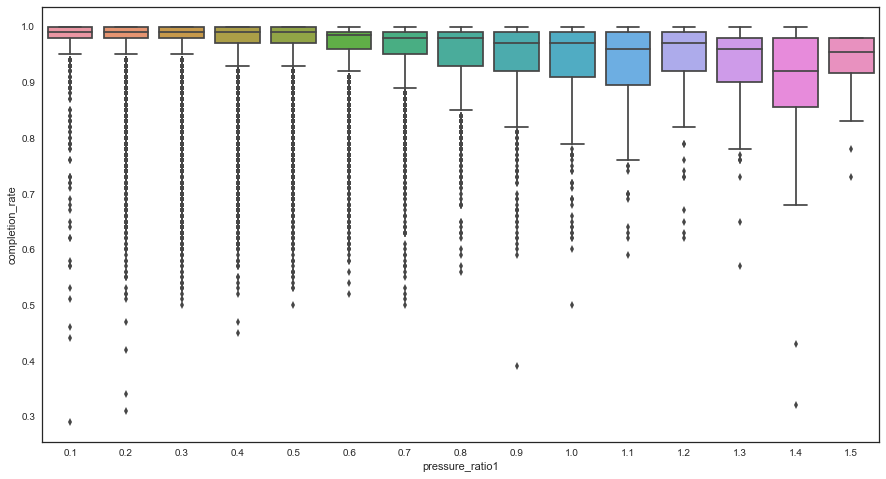

In [26]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='completion_rate',data=df5)